# Affordable Housing Survey in City of Charlottesville

This notebook is a part of a group collaboration with University of Virginia students, professors, and SmartCville. that looks at the affordability of single-family housing in the City of Charlottesville over the past 20 years. Hopefully, this project will gain insights into how difficult or easy it has been to obtain a single-family property across the City.

## Outline<a class="anchor" id="0"></a>
1. [Introduction](#1)
1. [Data Preprocessing](#2)
1. [Basic Visualization](#3)
1. [Classification into Neighborhood Planning Areas](#4)
    - [GeoJSON Layers](#4.1)
    - [Point in Polygon Algorithm](#4.2)
    - [Grouping the points](#4.3)
    - [Creation of Map](#4.4)
1. [Time Visualizations](#5)
1. [Parcels' sale histories](#6)
    - [Organizing Sale histories](#6.1)
    - [Which parcels have increased in sale price?](#6.2)
    - [Creation of Map](#6.3)

# 1 Introduction<a class="anchor" id="1"></a>
[Back to outline](#0)

The point of this study will be to observe housing prices in the City of Charlottesville. The following packages are imported. Numpy, geopandas, and pandas are used for data handling. Folium is used for data visualization; it is a Python wrapper for the Javascript library leaflet.



In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
import json
import datetime
import branca
from sklearn.preprocessing import MinMaxScaler
#These lines set up the plotting functionality and formatting.
import matplotlib
#matplotlib.use('Agg', warn=False)
#%matplotlib inline
import matplotlib.pyplot as plots
#plots.style.use('fivethirtyeight')
# import warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)


Municipal Boundary Area: https://opendata.charlottesville.org/datasets/municipal-boundary-area

The Folium module adapts Leaflet maps to Python. The provided coordinates (location=38.0393, -78.4767) will be used to generate all subsequent maps of the City of Charlottesville. Cville Open Data provides an approximate municipal boundary area in the form of a GeoJson/Json layer. The houses in this study are found within this boundary. Folium can take in GeoJson layers automatically as a layer.

In [2]:
with open ("data/cityboundary.geojson") as f:
    citylayer = json.load(f)

city_cville_coord=[38.0393, -78.4767]
map_with_citylayer = folium.Map(location=city_cville_coord, zoom_start=13)
folium.GeoJson(citylayer).add_to(map_with_citylayer)
map_with_citylayer

# 2 Data Preprocessing<a class="anchor" id="2"></a>
[Back to outline](#0)

The repository https://opendata.charlottesville.org/ offers data on various utilities in the City of Charlottesville. The previous section's Municipal Bounday Area is part of the Property subsection, which has various datasets. This section will extract the information that is useful for this study, formatting relevant portions of each table so that they are ready for Folium.

## 2.1 Reading/Modifying Sales Table<a class="anchor" id="2.1"></a>

Source: https://opendata.charlottesville.org/datasets/real-estate-sales

The _Sales Table_ contains data about sales of particular parcels. It contains their addresses, date of sale, and amount of sale. **_sales_** is a DataFrame that reads in this csv.

In [3]:
sales = pd.read_csv('data/Real_Estate__Sales_.csv')
sales

RecordID_Int ParcelNumber                SaleDate  SaleAmount  \
0                 1    010001000  2000/10/23 00:00:00+00           0   
1                 2    010001000  2016/02/10 00:00:00+00           0   
2                 3    010001100  2008/09/23 00:00:00+00           0   
3                 4    010001100  2008/09/23 00:00:00+00           0   
4                 5    010001100  2008/09/23 00:00:00+00           0   
...             ...          ...                     ...         ...   
56291         56277    610318000  2016/12/05 00:00:00+00           0   
56292         56278    610318000  1999/10/21 00:00:00+00       81500   
56293         56279    610318000  2017/03/07 00:00:00+00      148000   
56294         56280    610318000  2003/03/03 00:00:00+00      116900   
56295         56281    610318000  2013/01/22 00:00:00+00           0   

        StreetName StreetNumber Unit  
0       EMMET ST N         1117  NaN  
1       EMMET ST N         1117  NaN  
2      MILLMONT ST      1035-67  NaN  
3      MILLMONT ST      1035-67  NaN  
4      MILLMONT ST      1035-67  NaN  
...            ...          ...  ...  
56291  MILFORD TER          110  NaN  
56292  MILFORD TER          110  NaN  
56293  MILFORD TER          110  NaN  
56294  MILFORD TER          110  NaN  
56295  MILFORD TER          110  NaN  

[56296 rows x 7 columns]

The Street Number and Street Address are combined for ease of use later on. The Address column represents both of them. The two separate components to this address are then dropped.

In [4]:
sales['Address'] = sales['StreetNumber'] + ' '+sales['StreetName'] 
sales = sales.drop(columns=['StreetNumber','StreetName'])
sales

RecordID_Int ParcelNumber                SaleDate  SaleAmount Unit  \
0                 1    010001000  2000/10/23 00:00:00+00           0  NaN   
1                 2    010001000  2016/02/10 00:00:00+00           0  NaN   
2                 3    010001100  2008/09/23 00:00:00+00           0  NaN   
3                 4    010001100  2008/09/23 00:00:00+00           0  NaN   
4                 5    010001100  2008/09/23 00:00:00+00           0  NaN   
...             ...          ...                     ...         ...  ...   
56291         56277    610318000  2016/12/05 00:00:00+00           0  NaN   
56292         56278    610318000  1999/10/21 00:00:00+00       81500  NaN   
56293         56279    610318000  2017/03/07 00:00:00+00      148000  NaN   
56294         56280    610318000  2003/03/03 00:00:00+00      116900  NaN   
56295         56281    610318000  2013/01/22 00:00:00+00           0  NaN   

                   Address  
0          1117 EMMET ST N  
1          1117 EMMET ST N  
2      1035-67 MILLMONT ST  
3      1035-67 MILLMONT ST  
4      1035-67 MILLMONT ST  
...                    ...  
56291      110 MILFORD TER  
56292      110 MILFORD TER  
56293      110 MILFORD TER  
56294      110 MILFORD TER  
56295      110 MILFORD TER  

[56296 rows x 6 columns]

**_formatDate(row)_** is an applied function that takes every row of the DataFrame and modifies the SaleDate. The time portion is removed since none of the dates appear to specify an actual time. The backslashes are replaced with dashes to better coincide with numpy's date objects. **_sales_** now removes rows that do not have proper dates, and applies the **_formatDate(row)_** function. Comparing DF shapes, only one appeared to have an invalid date. Finally, the SalesDate column is converted into a pandas DateTime object.

In [5]:
def formatDate(row):  
    date = row['SaleDate']
    return date[:10].replace('/','-')

sales = sales[~pd.isna(sales.SaleDate)]
sales = sales.assign(SaleDate= sales.apply(formatDate,axis=1))
#sales['SaleDate'] = pd.DatetimeIndex(sales['SaleDate'])
sales

RecordID_Int ParcelNumber    SaleDate  SaleAmount Unit  \
0                 1    010001000  2000-10-23           0  NaN   
1                 2    010001000  2016-02-10           0  NaN   
2                 3    010001100  2008-09-23           0  NaN   
3                 4    010001100  2008-09-23           0  NaN   
4                 5    010001100  2008-09-23           0  NaN   
...             ...          ...         ...         ...  ...   
56291         56277    610318000  2016-12-05           0  NaN   
56292         56278    610318000  1999-10-21       81500  NaN   
56293         56279    610318000  2017-03-07      148000  NaN   
56294         56280    610318000  2003-03-03      116900  NaN   
56295         56281    610318000  2013-01-22           0  NaN   

                   Address  
0          1117 EMMET ST N  
1          1117 EMMET ST N  
2      1035-67 MILLMONT ST  
3      1035-67 MILLMONT ST  
4      1035-67 MILLMONT ST  
...                    ...  
56291      110 MILFORD TER  
56292      110 MILFORD TER  
56293      110 MILFORD TER  
56294      110 MILFORD TER  
56295      110 MILFORD TER  

[56295 rows x 6 columns]

## 2.2 Merging Sales with Residential<a class="anchor" id="2.2"></a>

Source: https://opendata.charlottesville.org/datasets/real-estate-residential-details

The _Residential datasheet_ contains a list of all the residential parcels of the area. This is important to filter out the non-residential parcels located in the _Sales dataset_. The datasheet has a column called "UseCode" that specifies the type of residential building in the parcel. It was discovered that some of the labels in the column were not relevant to family housing (such as parking lots and vacant lands). Filtering was done to remove these parcels from the dataset, and of the fifty or so labels, about ten are left.


**_resid_** is the DataFrame after reading in this _Residential csv_. 

In [6]:
resid = pd.read_csv('data/Real_Estate__Residential_Details_.csv',header=0)
resid

RecordID_Int ParcelNumber StreetNumber   StreetName Unit  \
0                 1    010001600          600    MASSIE RD  NaN   
1                 2    010005000            0  BARRACKS RD  NaN   
2                 3    010006000         2028  BARRACKS RD  NaN   
3                 4    010007000         1930  BARRACKS RD  NaN   
4                 5    010008000            0  BARRACKS RD  NaN   
...             ...          ...          ...          ...  ...   
14669         14674    610314000          102  MILFORD TER  NaN   
14670         14675    610315000          104  MILFORD TER  NaN   
14671         14676    610316000          106  MILFORD TER  NaN   
14672         14677    610317000          108  MILFORD TER  NaN   
14673         14678    610318000          110  MILFORD TER  NaN   

                           UseCode             Style Grade  \
0      Multipurpose Bldg (College)           2 Story     A   
1                      Vacant Land               NaN   NaN   
2                    Single Family           2 Story     A   
3                    Single Family           2 Story     A   
4                      Vacant Land               NaN   NaN   
...                            ...               ...   ...   
14669       Single Family Attached    2 Sty Attached     C   
14670       Single Family Attached    2 Sty Attached     C   
14671       Single Family Attached    2 Sty Attached     C   
14672       Single Family Attached    2 Sty Attached     C   
14673       Single Family Attached  1.5 Sty Attached     C   

                         Roof    Flooring  ... Bedrooms HalfBathrooms  \
0                       Metal        None  ...        4             0   
1                         NaN         NaN  ...      NaN           NaN   
2      Architectural Shingles    Hardwood  ...        6             1   
3                       Slate    Hardwood  ...        5             1   
4                         NaN         NaN  ...      NaN           NaN   
...                       ...         ...  ...      ...           ...   
14669  Architectural Shingles  W/W Carpet  ...        3             1   
14670  Architectural Shingles  W/W Carpet  ...        3             1   
14671  Architectural Shingles  W/W Carpet  ...        3             1   
14672  Architectural Shingles  W/W Carpet  ...        3             1   
14673  Architectural Shingles  W/W Carpet  ...        3             0   

       FullBathrooms BasementGarage Basement FinishedBasement  \
0                  4              0      0.0              0.0   
1                NaN            NaN      0.0              0.0   
2                  4              0   1018.0            900.0   
3                  4              0   1708.0           1468.0   
4                NaN            NaN      0.0              0.0   
...              ...            ...      ...              ...   
14669              1              0      NaN              NaN   
14670              2              0      NaN              NaN   
14671              1              0      NaN              NaN   
14672              1              0      NaN              NaN   
14673              2              0      NaN              NaN   

           BasementType ExternalWalls  NumberOfStories  \
0           No Basement          Wood             2.00   
1                   NaN           NaN              NaN   
2      Partial Basement  Brick Veneer             2.00   
3      Partial Basement  Brick Veneer             2.00   
4                   NaN           NaN              NaN   
...                 ...           ...              ...   
14669       No Basement         Vinyl             2.00   
14670       No Basement         Vinyl             2.00   
14671       No Basement         Vinyl             2.00   
14672       No Basement         Vinyl             2.00   
14673       No Basement         Vinyl             1.75   

       SquareFootageFinishedLiving  
0                           3672.0  
1                           

**_salesResid_** is the result of merging the **_sales_** and **_resid_**. Only parcels of UseCodes in the set **_labels_** are included. The join is done using the ParcelNumber from each dataframe.

In [7]:
# Filter out non-residential parcels
labels = {'Single Family', 'Duplex', 'Single Family Attached', 'Condominium',
          'Single Family-1 Conversion', 'Triplex', 'Rooming House', 'Condo Main',
          'Single Family-3 Conversion', 'Four-Level Split', 'Three-Level Split',
          'Single Family-2 Conversion', 'Condominium-Flex', 'Quadplex'}

salesResid = pd.merge(sales,resid[resid.UseCode.isin(labels)].loc[:,['ParcelNumber','UseCode']],on="ParcelNumber")
salesResid

RecordID_Int ParcelNumber    SaleDate  SaleAmount Unit  \
0                60    010006000  1995-05-25           0  NaN   
1                61    010006000  2003-02-20           0  NaN   
2                62    010006000  2003-01-31      545000  NaN   
3                63    010007000  1982-07-27      160000  NaN   
4                66    010009000  1984-08-31      175000  NaN   
...             ...          ...         ...         ...  ...   
48052         56277    610318000  2016-12-05           0  NaN   
48053         56278    610318000  1999-10-21       81500  NaN   
48054         56279    610318000  2017-03-07      148000  NaN   
48055         56280    610318000  2003-03-03      116900  NaN   
48056         56281    610318000  2013-01-22           0  NaN   

                Address                 UseCode  
0      2028 BARRACKS RD           Single Family  
1      2028 BARRACKS RD           Single Family  
2      2028 BARRACKS RD           Single Family  
3      1930 BARRACKS RD           Single Family  
4      1920 BARRACKS RD           Single Family  
...                 ...                     ...  
48052   110 MILFORD TER  Single Family Attached  
48053   110 MILFORD TER  Single Family Attached  
48054   110 MILFORD TER  Single Family Attached  
48055   110 MILFORD TER  Single Family Attached  
48056   110 MILFORD TER  Single Family Attached  

[48057 rows x 7 columns]

## 2.3 Merging with Geocoded Addresses<a class="anchor" id="2.3"></a>

The addresses in the table were then geocoded (found latitude/longitude coordinates using addresses) and located in a .csv file called _'coordinates.csv'_. This was merged with the combined **_salesResid_** table. **_geoSalesResid_** is the table that will be used for subsequent sections. As a baseline, parcels with SaleAmounts less than 100 were assumed to be typos or invalid sales and filtered out. Additionally, it was found that some parcels had sales with different 'RecordID', but with the same exact 'SaleDate', 'SaleAmount', and 'ParcelNumber'. These would also be filtered out. 

In [8]:
geocoded = pd.read_csv('data/coordinates.csv')

geoSalesResid = pd.merge(salesResid,geocoded,left_on="Address",right_on="ADDRESS")
geoSalesResid = geoSalesResid[geoSalesResid.SaleAmount > 100].drop(columns=["ADDRESS"])
geoSalesResid = geoSalesResid.drop_duplicates(subset=['ParcelNumber','SaleDate','SaleAmount'])
geoSalesResid

RecordID_Int ParcelNumber    SaleDate  SaleAmount Unit  \
2                62    010006000  2003-01-31      545000  NaN   
3                63    010007000  1982-07-27      160000  NaN   
4                66    010009000  1984-08-31      175000  NaN   
7                69    010010000  2018-10-31      575000  NaN   
8                70    010011000  2018-01-10      970000  NaN   
...             ...          ...         ...         ...  ...   
48019         56275    610318000  2001-07-20       89900  NaN   
48020         56276    610318000  1999-02-18       93000  NaN   
48022         56278    610318000  1999-10-21       81500  NaN   
48023         56279    610318000  2017-03-07      148000  NaN   
48024         56280    610318000  2003-03-03      116900  NaN   

                Address                 UseCode   LATITUDE  LONGITUDE  
2      2028 BARRACKS RD           Single Family  38.050765 -78.498080  
3      1930 BARRACKS RD           Single Family  38.050395 -78.497636  
4      1920 BARRACKS RD           Single Family  38.049731 -78.497104  
7      1851 WESTVIEW RD           Single Family  38.048508 -78.498668  
8      1855 WESTVIEW RD           Single Family  38.049037 -78.498346  
...                 ...                     ...        ...        ...  
48019   110 MILFORD TER  Single Family Attached  38.018268 -78.470688  
48020   110 MILFORD TER  Single Family Attached  38.018268 -78.470688  
48022   110 MILFORD TER  Single Family Attached  38.018268 -78.470688  
48023   110 MILFORD TER  Single Family Attached  38.018268 -78.470688  
48024   110 MILFORD TER  Single Family Attached  38.018268 -78.470688  

[30618 rows x 9 columns]

# 3 Basic Visualization<a class="anchor" id="3"></a>
[Back to outline](#0)

The goal of this section is to begin making visualizations of houses and their sale prices. 

**_makeRecentSales(cutoffDate)_** is a function that creates a subset of **_geoSalesResid_** based on a cutoff date. It will only look at sales that have happened after the specified date. **_recentSales_** is an example DataFrame created that has sales from the beginning of 2019 to the end of 2019. The end of 2019 was chosen to be the standard end date since 2020 has not as of yet finished. 

In [9]:
def makeRecentSales(cutoffDate):
    return geoSalesResid[(geoSalesResid.SaleDate > cutoffDate) & (geoSalesResid.SaleDate < '2020-01-01')]

recentSales = makeRecentSales('2018-12-31')

A Folium map can be generated with circle markers describing a coordinate that has latitude and longitude. **_addMarkersSale_** is an applied function that will read the rows of the DataFrame and add a circle marker to it. The color will be chosen using the **_chooseColor_** function which defines the sale cutoffs that will be used on the map. It uses the Yellow/Orange/Red color brewer gradient. The markers will also show the Sale Date and Amount for each. **_formatSalesNumber(v)_** is a helper function that adds commas every third digit in the sale.

In [10]:
def formatSalesNumber(v):
    # split it between left/right of decimal point
    splitstr = v.split('.')
    
    # left num is first entry of split list, then count number of digits it has
    leftNum = splitstr[0]
    leftNumDigits = len(splitstr[0])
    
    # if there exists num right of point, then set it to right Num
    if len(splitstr) > 1:  
        rightNum = '.' + splitstr[1]
    else:
        rightNum = '.00'
    
    # Count number of commas necessary
    comma = 0
    if leftNumDigits > 3:
        temp = leftNumDigits
        while(((temp -1) // 3) > 0):
            temp -= 3 
            comma += 1
    else:
        return '$' + leftNum + rightNum

    # Produce the string
    if leftNumDigits % 3 == 0:
        s = '$' + leftNum[:3]
        for i in np.arange(comma):
            a = i + 1
            s += ','+ leftNum[3 * a:3 * a + 3]
        return s + rightNum
    else:
        s = '$' + leftNum[:(leftNumDigits % 3)]
        for i in np.arange(comma):
            a = i + 1 
            b = leftNumDigits % 3 
            s += ','+ leftNum[b * a : b * a + 3]
        return s + rightNum


def chooseColorSale(sale):
    if sale < 89000:
        return '#fef0d9'
    elif 89000 <= sale < 150000:
        return '#fdd49e'
    elif 150000 <= sale < 400000:
        return '#fdbb84'
    elif 400000 <= sale < 800000:
        return '#fc8d59'
    elif 800000 <= sale < 1000000:
        return '#e34a33'
    else:
        return '#b30000'

def addMarkersSale(row,currmap):
    line = row["SaleDate"][:] + ": " + formatSalesNumber(str(row['SaleAmount']))
    folium.CircleMarker(location=[row['LATITUDE'],row['LONGITUDE']],
                  popup=line,radius=1.5,color=chooseColorSale(row['SaleAmount']),
                       fill_color=chooseColorSale(row['SaleAmount'])).add_to(currmap)
    return

A Folium map is created, centered on Charlottesville. **_generateSalesMap()_** is just a function that encloses this process of generating a map. The functions described above are used to add circle markers to every parcel that had a Sale from beginning of 2019 to the present.

In [11]:
def generateSalesMap():
    m = folium.Map(location=city_cville_coord, zoom_start=13)
    makeRecentSales('2018-12-31').apply(addMarkersSale,axis=1,args=(m,))
    return m
generateSalesMap()

# 4 Classification into Neighborhood Planning Areas<a class="anchor" id="4"></a>
[Back to outline](#0)

Planning Neighborhood Area: https://opendata.charlottesville.org/datasets/planning-neighborhood-area

The goal of this section is to make use of special zones in the City. The Neighborhod Development Services (NDS) createad a Cville OpenData file that lists "Planning Neighborhood Areas". Using this and the points-in-polygon problem, each property will now be able to be classified into a planning neighborhood area based on their latitude and longitude coordinates obtained from [section 2.3](#2.3).

## 4.1 GeoJSON Layers<a class="anchor" id="4.1"></a>

From the map in the previous [section](#3), it can be seen that there are exist clusters of similar sale prices. JSON object files are a good way to represent geographical areas. Cville Open Data provides a set of objects called Planning Neighborhood Areas, and said set is used as a layer. **_generateJSONMap()_** produces a map of Charlottesville with these Planning Areas overlayed. 

In [12]:
def generateJSONMap():
    m = folium.Map(location=city_cville_coord, zoom_start=13)
    folium.GeoJson("data/regions.geojson", name='area').add_to(m)
    return m
generateJSONMap()

The GeoJson file has a lot of additional information for each layer. The latitude/longitude of each layer are extracted from this. The variable **_lay_** is a list of coordinate lists. 

In [13]:
layoutFile = json.load(open('data/regions.geojson'))
arr = []
for i in np.arange(len(layoutFile['features'])):
    arr.append(layoutFile['features'][i]['geometry']['coordinates'][0])
lay = pd.Series(arr)

To combine these individual parcel points with the imported JSON layer into a cohesive visualization, the Point in Polygon problem must be solved. How can we automate the process of determining which region a house belongs to? The next section will describe the algorithm that ultimately determines whether a parcel (point) is located within a particular JSON object (polygon). 

## 4.2 Point in Polygon Algorithm<a class="anchor" id="4.2"></a>

With the imported JSON polygon layers, each point in the previous section should be grouped with each polygon. This is a point in polygon problem: determine whether or not a point is in a polygon defined by its vertices (set of points). 

A way to solve this problem is with ray-casting. Take a point and extend it "infinitely" along an arbitrary direction (it is now a ray). Count the number of times the point intersects a side of the polygon. If the number of ray intersections is even, then it is not in the polygon. If the number of ray intersections is odd, then it is in the polygon. 

![Solving PIP with Ray-casting](https://upload.wikimedia.org/wikipedia/commons/c/c9/RecursiveEvenPolygon.svg)


The first issue is, given two pairs of points (that define two line segments), determine if they intersect or not. The solution is to check the orientation of these points (intersecting line segments should have their respective points in between one point from the other line segment). A algorithm written by Kite is used. The main function below is intersects(s1,s2) and it takes in two tuples.

**Note: All credit for the functions _on_segment(p,q,r)_, _orientation(p,q,r)_, and _intersects(s1,s2)_ goes to Kite [https://www.kite.com/python/answers/how-to-check-if-two-line-segments-intersect-in-python].** 

In [14]:
def on_segment(p,q,r):
    if r[0] <= max(p[0], q[0]) and r[0] >= min(p[0], q[0]) and r[1] <= max(p[1], q[1]) and r[1] >= min(p[1], q[1]):
        return True
    else: 
        return False

def orientation(p,q,r):
    val = ((q[1] - p[1]) * (r[0] - q[0])) - ((q[0] - p[0]) * (r[1] - q[1]))
    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return -1

def intersects(s1,s2):
    p1,q1 =s1
    p2,q2 = s2
    
    o1 = orientation(p1,q1,p2)
    o2 = orientation(p1,q1,q2)
    o3 = orientation(p2,q2,p1)    
    o4 = orientation(p2,q2,q1)
    
    if o1 != o2 and o3 != o4:
        return True
    if o1 == 0 and on_segment(p1,q1,p2):
        return True
    if o2 == 0 and on_segment(p1, q1, q2):
        return True
    if o3 == 0 and on_segment(p2, q2, p1):
        return True
    if o4 == 0 and on_segment(p2, q2, q1):
        return True
    return False

Now the point in polygon algorithm can be applied for this scenario. 

The main function is **_pointinpolygons(row,layout)_**, which will be applied across the entire table with each row (point) as its argument. It will return a series of booleans showing whether or not the point is in each of the polygons in the JSON file.

The **_makeray(point)_** function receives a point and returns a sequence with two tuples inside that represent the ray. For this, each point is extended horizontally. Additionally, since all points reside in Charlottesville, the left/right longitude are the west-most/east-most points of the area, respectively. 

The **_pointinpolygon(polygons,raysegment)_** function is the individual function that is applied inside pointinpolygons. It creates a list of tuples that contain the line segments of the polygon. It is assumed that the Json file is configured so that the points can be connected from smallest to biggest (index 0 to index 1, index 1 to index 2, etc) until the very last which is connected back to index 0. It then counts the number of intersections as described above about the ray-casting. 

In [15]:
# defines a point, returns a series of whether or not point is in each JSON polygon
def pointinpolygons(row,layout):
    pt = (row['LATITUDE'],row['LONGITUDE'])
    rayseg = makeray(pt)
    
    foundin = layout.apply(pointinpoly,args=(rayseg,))
    if foundin[foundin].shape[0] == 0:
        return 0
    else:
        return foundin[foundin].index[0] + 1
    

# produces a ray by extending a point horizontally depending on its longitude relative to Cville
def makeray(point):
    # Bounds for Longitude 
    leftb = -78.647930
    rightb = -78.411250
    midb = leftb + (rightb-leftb)/2

    if point[1] > midb:
        return (point,(point[0],leftb)) 
    else:
        return (point,(point[0],rightb))
    
# determines if the point is in or not in a single JSON polygon
def pointinpoly(polygons,raysegment):
    # Makes pairs of indices to form polygon edges (assumes that edges are defined as) from a polygon that has n sides
    # 0 to 1, 1 to 2, 2 to 3, etc... until the last index which would be n-1 to 0
    combo = []
    for i in np.arange(len(polygons)):
        if i < len(polygons) - 1:
            apair = (i,i+1)
        else:
            apair = (i,0)
        combo.append(apair)
    
    # Iterates through the list of pairs and indexes into the polygons variable which is a list of lists. It produces a 
    # a segment represented by two points and it is determined whether it intersects with the address.
    intersections = 0 
    for pair in combo:
        segment1 = ((polygons[pair[0]][1],polygons[pair[0]][0]), (polygons[pair[1]][1],polygons[pair[1]][0]))
        if intersects(segment1,raysegment):
            intersections +=1
            
    if intersections % 2 == 0:
        return False
    else:
        return True

The function is used to insert a column that assigns each point to its polygon region. If it is not in any of the polygons, then it is assigned 0. The recentSales table that contained sales after 2018 adds a new column that categorizes each parcel into an area.

In [16]:
recentSales.insert(recentSales.shape[1],'Region',recentSales.apply(pointinpolygons,axis=1,args=(lay,)))

To verify the accuracy of the algorithm, the same table is used to create another map with the Json layers. Filtering out those without a region, there does not seem to be a point that lies outside the polygons. **_generateSalesMapWithJson()_** uses **_recentSales_** and filters out those without a region (classifed with 0). In fact, there does not appear to be any house that is actually part of region 0, meaning that none in the dataset were outside of the City of Cville area.

In [17]:
def generateSalesMapWithJson():
    m = folium.Map(location=city_cville_coord, zoom_start=13)
    testTab = recentSales[recentSales.Region >0].apply(addMarkersSale,axis=1,args=(m,))
    folium.GeoJson("data/regions.geojson", name='area').add_to(m)
    return m

generateSalesMapWithJson()

## 4.3 Grouping the points<a class="anchor" id="4.3"></a>

The pandas group function can be used to group all the points by region and determine the average sale amount within that region. **_salesByRegion_** is an example of grouping the entire **_recentSales_** table by region and finding the average of their sale prices to form a Series.

In [18]:
salesByRegion = recentSales.groupby(['Region']).mean().loc[:,"SaleAmount"]
salesByRegion

Region
1     717857.860465
2     511822.775000
3     314556.120000
4     368137.540230
5     441875.581395
6     200313.800000
7     314220.600000
8     241635.603448
9     357772.259259
10    292720.743590
11    750000.000000
12    105000.000000
13    328184.814516
14    358465.073171
15    767669.529412
16    586843.750000
17    278134.142857
18    207666.666667
19    563986.363636
Name: SaleAmount, dtype: float64

In [19]:
def classifyHouses(df):
    df.insert(df.shape[1],'Region',df.apply(pointinpolygons,axis=1,args=(lay,)))
    df.to_csv('data/salesLast20Years.csv')
    return 

run_already = True
if not run_already:
    classifyHouses(makeRecentSales('1999-12-31'))

A style function tells Folium how to format the JSON layers onto the map. This is necessary to customize GeoJSON layers in Folium. The color tiers similarily follow the function **_chooseColorSale()_** in [section 3](#3).

In [20]:
def stylefunction(x):  
    sale=x['properties']['SaleAverage']
    if sale < 89000:
        color = '#fef0d9'
    elif 89000<= sale < 150000:
        color = '#fdd49e'
    elif 150000 <= sale < 400000:
        color = '#fdbb84'
    elif 400000 <= sale < 800000:
        color = '#fc8d59'
    elif 800000 <= sale < 1000000:
        color = '#e34a33'
    else:
        color = '#b30000'
    return {'weight': 5, 'color': color,'fill': True, 'fillOpacity':0.5}

## 4.4 Creation of the Map<a class="anchor" id="4.4"></a>

Some helper functions are created to ensure that the main map generation function is not too cluttered.
1. **_produceAGroup(t,func,label)_**: Make a DataFrame based on grouping the Regions and calculating a value (mean/med/count)
2. **_checkIfZero(s,l,n)_**: Exception checking if no sales in a region, then it will just return 0.
3. **_addMarkersSaleGroup(row,currmap,group)_**: Add markers to map and to the markers group, color based on sales price and the label shows House type, price, and year.

In [21]:
def produceAGroup(t,func,label):
    if func == 'mean':
        temp = t.groupby(['Region']).mean().loc[:,label]
        return pd.DataFrame({'Regions': pd.Series(data=np.arange(20)), 'Avg': temp}).fillna(value=0)
    elif func == 'median':
        temp = t.groupby(['Region']).median().loc[:,label]
        return pd.DataFrame({'Regions': pd.Series(data=np.arange(20)), 'Med': temp}).fillna(value=0)          
    elif func == 'count':
        temp = t.groupby(['Region']).count().iloc[:,0]
        return pd.DataFrame({'Regions': pd.Series(data=np.arange(20)), 'Count': temp}).fillna(value=0)
    

def checkIfZero(s,l,n):
    try:
        return str(round(s[l][n],2))
    except:
        return '0'

def addMarkersSaleGroup(row,currmap,group):
    # normalized to day (percNorm)
    price = row['SaleAmount']
    line = row ["UseCode"] + '(' + row["SaleDate"][:4] + "): " + formatSalesNumber(str(row['SaleAmount']))
    marker = folium.CircleMarker(location=[row['LATITUDE'],row['LONGITUDE']],
          popup=line,radius=1.5,color=chooseColorSale(price),
               fill_color=chooseColorSale(price))
    group.add_child(marker)
    return

The **_generateSalesMap(salesTable)_** function will do the following:

1. Import the saved table that has run pointinpolygons
2. Drop the redundant column at the beginning
3. Group the salesTable by the regions and determine the mean/median/count of each. Make a DataFrame for all three with the numerical indices as a column. Uses **_produceAGroup(t,func,label)_ function**
4. Load JSON file of planning areas and update each layer with the three values. Uses **_checkIfZero(s,l,n)_ function**
5. Load JSON file of city boundary and add median/average/count to JSON
6. Create a Folium Map and include additional Tile options
7. FeatureGroup: Add a GeoJSON of city boundary that includes average/median of whole city
8. FeatureGroup: Add the markers of individual parcels onto the map. Uses **_addMarkersSaleGroup(row,currmap,group)_ function**
9. FeatureGroup: Add a Choropleth using DataFrame from #3 and JSON from #4 based on averages
10. FeatureGroup: Add a Choropleth using DataFrame from #3 and JSON from #4 based on median
11. Add LayerControl and save map

In [22]:
def generateSalesMap():
    # 1. Import the saved Table
    salesTable = pd.read_csv('data/salesLast20Years.csv') 
    
    # 2. Drop the redundant column
    salesTable = salesTable.drop(columns='Unnamed: 0')
    
    # 3. Group by region number and find average sale amount and median in each, even for region 0. Produce a DataFrame that has
    # the region numbers as a column
    salesByRegionAvg = produceAGroup(salesTable,'mean','SaleAmount')
    salesByRegionMed = produceAGroup(salesTable,'median','SaleAmount')
    salesByRegionCount = produceAGroup(salesTable,'count','SaleAmount')
    
    print("Creating the map")
    # 4. load GeoJSON file of regions, adding the SaleAverage as a property to each
    with open ("data/regions.geojson") as f:
        regionlayer = json.load(f)
        count = 1
        for i in regionlayer['features']:
            i['properties']['AVG PRICE'] = formatSalesNumber(checkIfZero(salesByRegionAvg,'Avg',count))
            i['properties']['MED PRICE'] = formatSalesNumber(checkIfZero(salesByRegionMed,'Med',count))
            i['properties']['NUM SALES'] = salesByRegionCount.Count[count]
            count += 1
            
    
    # 5. Load GeoJSON of city boundary, adding SaleAverage/Median/Count of whole city to the Layer
    with open ("data/cityboundary.geojson") as f:
        citylayer = json.load(f)
    citylayer['features'][0]['properties']['AVG PRICE'] = formatSalesNumber(str(round(salesTable.SaleAmount.mean(),2)))
    citylayer['features'][0]['properties']['MED PRICE'] = formatSalesNumber(str(round(salesTable.SaleAmount.median(),2)))
    citylayer['features'][0]['properties']['NUM SALES'] = salesTable.shape[0]

        
    # 6. Create Folium Map and add TileLayer Options      
    m = plugins.DualMap(location=city_cville_coord, zoom_start=13)
    folium.raster_layers.TileLayer('Open Street Map').add_to(m)
    folium.raster_layers.TileLayer('Stamen Toner').add_to(m)
    folium.raster_layers.TileLayer('CartoDB Positron').add_to(m)

    # 7. Group: GeoJson of Charlottesville City Boundary
    cityavg = salesTable.SaleAmount.mean()
    style_function = lambda x: {'fillColor': chooseColorSale(cityavg), 'color': chooseColorSale(cityavg)}
    city = folium.GeoJson(citylayer, name='City of Charlottesville Boundary',
                   style_function=style_function,
                         tooltip=folium.GeoJsonTooltip(['NAME','AVG PRICE','MED PRICE', 'NUM SALES'])).add_to(m)

    # 8. Group: Addition of Markers for each individual Parcel
    saleMarkers = folium.FeatureGroup(name='Sale Price Markers',show=False)
    salesTable.apply(addMarkersSaleGroup,axis=1,args=(m,saleMarkers))
    m.add_child(saleMarkers)

    # 9. Group: Choropleth of Planning Neighborhood Regions' Average Sale
    choroAvg = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                      data=salesByRegionAvg,columns=['Regions','Avg'],
                      fill_color='YlOrRd',legend_name='Sale Amount ($): Average',name='Sale Amount Average', show=False,
                      
                      highlight=True).add_to(m.m1)
    choroAvg.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','AVG PRICE','NUM SALES']))
 
    # 10. Group: Choropleth of Planning Neighborhood Regions' Median Sale
    choroMed = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                      data=salesByRegionMed,columns=['Regions','Med'],
                      fill_color='YlOrRd',legend_name='Sale Amount ($): Median',name='Sale Amount Median', show=False,
                      highlight=True).add_to(m.m2)
    choroMed.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','MED PRICE','NUM SALES']))
    
    
    # 11. Add LayerControl and Save Map
    folium.LayerControl().add_to(m)
    m.save("maps/salesMapLast20Years.html")
    return 

generateSalesMap()

Creating the map


This section is just to separate the dual map into one that is mean and one that is median. This is to provide an alternative in case the dual, combined map appears to be too cluttered.

In [ ]:
def generateSalesMapSeparate():
    # 1. Import the saved Table
    salesTable = pd.read_csv('data/salesLast20Years.csv') 
    
    # 2. Drop the redundant column
    salesTable = salesTable.drop(columns='Unnamed: 0')
    
    # 3. Group by region number and find average sale amount and median in each, even for region 0. Produce a DataFrame that has
    # the region numbers as a column
    salesByRegionAvg = produceAGroup(salesTable,'mean','SaleAmount')
    salesByRegionMed = produceAGroup(salesTable,'median','SaleAmount')
    salesByRegionCount = produceAGroup(salesTable,'count','SaleAmount')
    
    print("Creating the map")
    # 4. load GeoJSON file of regions, adding the SaleAverage as a property to each
    with open ("data/regions.geojson") as f:
        regionlayer = json.load(f)
        count = 1
        for i in regionlayer['features']:
            i['properties']['AVG PRICE'] = formatSalesNumber(checkIfZero(salesByRegionAvg,'Avg',count))
            i['properties']['MED PRICE'] = formatSalesNumber(checkIfZero(salesByRegionMed,'Med',count))
            i['properties']['NUM SALES'] = salesByRegionCount.Count[count]
            count += 1
            
    
    # 5. Load GeoJSON of city boundary, adding SaleAverage/Median/Count of whole city to the Layer
    with open ("data/cityboundary.geojson") as f:
        citylayer = json.load(f)
    citylayer['features'][0]['properties']['AVG PRICE'] = formatSalesNumber(str(round(salesTable.SaleAmount.mean(),2)))
    citylayer['features'][0]['properties']['MED PRICE'] = formatSalesNumber(str(round(salesTable.SaleAmount.median(),2)))
    citylayer['features'][0]['properties']['NUM SALES'] = salesTable.shape[0]

        
    # 6. Create Folium Map and add TileLayer Options      
    m = plugins.DualMap(location=city_cville_coord, zoom_start=13)
    folium.raster_layers.TileLayer('Open Street Map').add_to(m)
    folium.raster_layers.TileLayer('Stamen Toner').add_to(m)
    folium.raster_layers.TileLayer('CartoDB Positron').add_to(m)

    # 7. Group: GeoJson of Charlottesville City Boundary
    cityavg = salesTable.SaleAmount.mean()
    style_function = lambda x: {'fillColor': chooseColorSale(cityavg), 'color': chooseColorSale(cityavg)}
    city = folium.GeoJson(citylayer, name='City of Charlottesville Boundary',
                   style_function=style_function,
                         tooltip=folium.GeoJsonTooltip(['NAME','AVG PRICE','MED PRICE', 'NUM SALES'])).add_to(m)

    # 8. Group: Addition of Markers for each individual Parcel
    saleMarkers = folium.FeatureGroup(name='Sale Price Markers',show=False)
    salesTable.apply(addMarkersSaleGroup,axis=1,args=(m,saleMarkers))
    m.add_child(saleMarkers)

    # 9. Group: Choropleth of Planning Neighborhood Regions' Average Sale
    choroAvg = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                      data=salesByRegionAvg,columns=['Regions','Avg'],
                      fill_color='YlOrRd',legend_name='Sale Amount ($): Average',name='Sale Amount Average', show=False,
                      
                      highlight=True).add_to(m.m1)
    choroAvg.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','AVG PRICE','NUM SALES']))
 
    # 10. Group: Choropleth of Planning Neighborhood Regions' Median Sale
    choroMed = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                      data=salesByRegionMed,columns=['Regions','Med'],
                      fill_color='YlOrRd',legend_name='Sale Amount ($): Median',name='Sale Amount Median', show=False,
                      highlight=True).add_to(m.m2)
    choroMed.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','MED PRICE','NUM SALES']))
    
    
    # 11. Add LayerControl and Save Map
    folium.LayerControl().add_to(m)
    m.save("maps/salesMapLast20Years.html")
    return 

generateSalesMap()

# 5 Timesliders<a class="anchor" id="5"></a>
[Back to outline](#0)

Folium includes plugins from the Leaflet library, with some useful ones including time as a variable in map visualizations. This section will create visuals that can be varied through the last 20 years. Two plugins used are TimesliderChoropleth and HeatMapwithTime.

## 5.1 Timeslider Choropleth

Timeslider choropleth is similar to a regular choropleth in that both represent variables in regions using a gradient. However, the former can take in timestamps (time from a fixed date) and produce a draggable slider for time.

First, the **_mean_med_byregion()_** is a function that imports the saved tables of sales in the last 20 years (that includes which region it is located in). It will then group sales by the sale date year and by region and find the average and median of each group. This will then be inserted into two DataFrames that will be exported. **_makeSalesTableByYear(t,y)_** is a helper function that returns a subset of the DataFrame in which only sales within a given range are included.

As seen from **_avg_by_region_**, each region will have an average sale and median sale for every year from 2000 to 2020.

In [23]:
def makeSalesTableByYear(t,y):
    start = str(y-1) + '-12-31'
    end = str(y+1) + '01-01'
    return t[(t.SaleDate > start) & (t.SaleDate < end)]

def mean_med_byregion():
    avg_tab = pd.DataFrame(np.zeros((19,20)),index=np.arange(1,20),columns=[str(x) for x in np.arange(2000,2020)])
    med_tab = avg_tab.copy()
    table = pd.read_csv('data/salesLast20Years.csv')
    
    for i in np.arange(2000,2020):
        temp = makeSalesTableByYear(table,i)
        avg_tab[str(i)] = temp.groupby(['Region']).mean().loc[:,'SaleAmount']
        med_tab[str(i)] = temp.groupby(['Region']).median().loc[:,'SaleAmount']
    
    avg_tab = avg_tab.fillna(0)
    med_tab = med_tab.fillna(0)
    
    return avg_tab,med_tab

avg_by_region, med_by_region = mean_med_byregion()
avg_by_region

2000           2001           2002           2003           2004  \
1   191682.295918  195886.862385  229277.091743  293774.490566  329402.792453   
2   163437.757143  200869.136986  200951.656716  220263.453125  278552.917647   
3    94510.021739  112521.763636  172194.412500  192404.141176  164461.024691   
4   139324.650485  151898.284314  178637.163934  208053.268293  234418.076389   
5   190208.817308  218400.581633  247598.160920  263562.442308  289768.088496   
6   147265.789474  155957.352941  150967.647059  162707.047619  194664.866667   
7   343734.756944  386299.730667  123645.382838  160023.058047  192412.155612   
8    81931.956522   85457.993151   99482.505435  125572.947368  153970.613757   
9   134304.758621  134239.923077  167643.269231  202458.870968  221072.000000   
10   79317.235294   86603.740000  166284.986111  316928.093750  324567.000000   
11   66625.000000  110785.714286  187062.500000  158633.333333  123742.857143   
12   63294.444444   72625.000000   79500.000000   89500.000000  106700.000000   
13  140800.000000  149693.870968  173618.864865  194377.650602  219436.564593   
14  113526.387097  158362.333333  190747.368421  191664.592593  282367.849315   
15  291186.521739  367338.333333  413411.428571  420882.857143  446246.666667   
16  176813.521739  196208.068966  199911.323077  308849.624000  363026.153153   
17   64257.000000   61366.666667   72563.743590   96667.804348  130432.523810   
18   57940.000000   63196.545455   75172.571429  108693.333333  129070.000000   
19  203978.750000  224007.747748  256748.035714  298563.664596  342107.551020   

             2005          2006          2007           2008           2009  \
1   426188.960938  4.798084e+05  4.546566e+05  424802.409091  460578.097222   
2   286630.454545  3.262434e+05  4.412044e+05  434232.980392  321978.756098   
3   167020.134831  1.982507e+05  3.493463e+05  372297.425532  390018.485714   
4   275559.418182  2.962844e+05  2.715699e+05  254689.734940  243300.348485   
5   347167.045455  3.655263e+05  3.684871e+05  345295.474576  316922.368421   
6   191624.068966  1.571905e+05  1.920954e+05  211743.142857  195049.000000   
7   217297.821839  2.282364e+05  2.272875e+05  219641.811159  204029.867925   
8   198988.218254  3.151571e+05  3.700668e+05  186027.587786  198929.500000   
9   249984.560000  3.465716e+05  4.170765e+05  431583.893491  649794.384615   
10  482439.934211  4.996102e+05  3.401817e+05  293939.451923  282908.325581   
11  170333.333333  1.875000e+05  2.242110e+05  221418.444444  238329.111111   
12  136355.555556  1.384625e+05  1.352500e+05  146500.000000  196000.000000   
13  249690.024590  2.725612e+05  2.862441e+05  275523.310606  248864.745614   
14  348068.765432  3.289486e+05  3.222845e+05  306750.153061  228124.065574   
15  650704.166667  9.403948e+05  9.567106e+05  480312.500000  431433.500000   
16  324567.159091  8.456186e+05  9.863354e+05  395742.214286  413963.019608   
17  153823.477273  6.125027e+05  6.575355e+05  152257.413793  178393.750000   
18  210768.750000  1.144225e+06  1.320538e+06  142875.000000  119879.000000   
19  466759.200000  5.432544e+05  4.538322e+05  417609.866667  454004.113924   

             2010           2011           2012           2013           2014  \
1   497340.252525  460955.980000  420658.234694  458520.567010  481614.744186   
2   351269.960784  319574.968750  313761.477612  369592.786885  369444.642857   
3   358187.975000  218509.476190  221777.229167  213980.024390  277469.650000   
4   231783.328358  254787.460317  255455.831169  236579.465116  262656.893617   
5   315284.702703  306011.689655  308824.243902  327563.000000  339083.797468   
6   164056.294118  268002.913043  284040.000000  174065.166667  192233.650000   
7   188015.522727  185890.656250  201973.798419  219900.988722  239887.590164   
8   227141.206731  204060.103627  170076.484472  175690.820000  186566.253623   
9   848224.317073  278248.473684  259775.230769  270205.818182  308276.923077   
1

Two helper functions are made to produce the timeslider map. 

**_chooseColorTime(sale)_** is a helper function that is analogous to those in previous sections in that it will determine the color of each choropleth object based on the sales range.

**_makestyledict(sale)_** is a function that produces a style dictionary detailing the color of each region. It uses **_chooseColorTime(sale)_** as a helper function to determine the color. It first converts the date from a datetime format (MMM/DD/YYYY) to a unix integer that is the number of seconds since epoch (1/1/1970). It uses dictionary comprehension to make a nested dictionary. Outside keys are region numbers and inside keys are the time integer.

In [24]:
def chooseColorTime(sale):
    if sale < 89000:
        return '#fef0d9'
    elif 89000<= sale < 150000:
        return '#fdd49e'
    elif 150000 <= sale < 300000:
        return '#fdbb84'
    elif 300000 <= sale < 500000:
        return '#fc8d59'
    elif 500000 <= sale < 800000:
        return '#e34a33'
    else:
        return '#b30000'

def makestyledict():
    datetime_index=pd.date_range(start='1/1/2000',end='1/1/2020',normalize=True,freq='A')
    dt_index_epochs=datetime_index.astype(int)//10**9
    dt_index=dt_index_epochs.astype(str)
    style = {
        str(outer_k): {
            inner_k: 0
            for inner_k in dt_index
        } 
        for outer_k in np.arange(1,20)
    }
    
    avg_by_region.columns=dt_index
    
    for region in style:
        for time in style[region]:
            saleavg = avg_by_region.at[int(region),str(time)]
            style[region][time] = {'color': chooseColorTime(saleavg) ,'opacity':1}
    return style

**_generateTimesliderMap()_** is a wrapper function that reads in the geojson file of all the regions, produces a map of Charlottesville, and then creates a Timeslider.

In [25]:
def generateTimesliderMap():
    r = gpd.read_file('data/regions.geojson').set_index('OBJECTID')
    m = folium.Map(location=city_cville_coord, zoom_start=13)
    g = plugins.TimeSliderChoropleth(r.to_json(), styledict=makestyledict(), overlay = True).add_to(m)
    return m

generateTimesliderMap()

## 5.2 Heat Map with Time

Another plugin produces a heat map that varies with time. The class takes in a list of list of coordinates, with the outer list being the time increment specified. The chosen time frame was in years, so the outer list has 20 lists corresponding to each of the past 20 years from 2000 to 2019.

In [164]:
def produceList(df):
    outer = []
    for year in np.arange(2000,2020):
        inner = []
        temp = df[df['SaleDate'].dt.year==year].copy()
        for house in temp.iterrows():
            innerer = []
            innerer.append(house[1].LATITUDE)
            innerer.append(house[1].LONGITUDE)
            innerer.append(house[1].SaleAmountScaled)
            inner.append(innerer)
        outer.append(inner)
    return outer


def generateHeatMapSales():
    df=pd.read_csv('data/salesLast20Years.csv')
    df=df.drop(columns='Unnamed: 0')
    df['SaleDate'] = pd.DatetimeIndex(df['SaleDate'])

    dfLog = df.copy()
    
    scaler = MinMaxScaler(feature_range=(0.0001,1))
    df['SaleAmountScaled'] = scaler.fit_transform(df.loc[:,'SaleAmount'].values.reshape(-1,1))
    
    scalerLog = MinMaxScaler(feature_range=(0.0001,1))
    dfLog['SaleAmountScaled'] = scaler.fit_transform(np.log(df.loc[:,'SaleAmount'].values.reshape(-1,1)))
    
    
    m = folium.Map(location=city_cville_coord, zoom_start=13)
    data = produceList(df)
    dataLog = produceList(dfLog)
    
    years = [i for i in np.arange(2000,2020)]
    g = plugins.HeatMapWithTime(data=data,index=years,name='Normal').add_to(m)
    g = plugins.HeatMapWithTime(data=dataLog,index=years,name = 'Log').add_to(m)
    
    style_function = lambda x: {'fillOpacity': 0, 'opacity': 0.5}

    folium.GeoJson("data/regions.geojson", style_function=style_function,name='area').add_to(m)

    
    folium.raster_layers.TileLayer('Open Street Map').add_to(m)
    folium.raster_layers.TileLayer('Stamen Toner').add_to(m)
    folium.raster_layers.TileLayer('CartoDB Positron').add_to(m)
    folium.LayerControl().add_to(m)
    m.save('maps/yo.html')
    return m

generateHeatMapSales()


<AxesSubplot:>

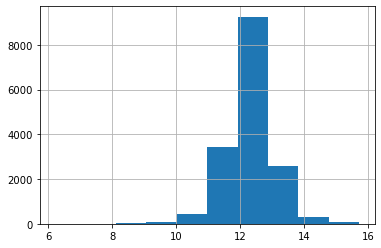

In [153]:
np.log(gg['SaleAmount']).hist()

In [ ]:
def f(df):
    #r = gpd.read_file('data/cat.geojson').set_index('OBJECTID')
    r = json.load(open('data/regions.geojson'))

    features= []
    count=0
    t=[]
    for row in df.iterrows():
        for index,val in row[1][6:].items():
            feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Polygon', 
                'coordinates':r['features'][count]['geometry']['coordinates']
            },
            'properties': {
                'ID': count,
                'times': str(int(index) * 1000),
                'style': {'color' : chooseColorTime(val)},
                }
            }        
            features.append(feature)
        count += 1
        
        #print(row)
    
    for i in features:
        print(i['properties']['times'])
#     print(ab)

#     for i in features:
#         print(pd.to_datetime(i['properties']['times'],unit='ms',origin='unix'))
    m = folium.Map(location=city_cville_coord, zoom_start=13)
    g = plugins.TimestampedGeoJson(
        {'type':'FeatureCollection','features':features},duration='P1M',date_options='YYYY/MM').add_to(m)
    return m

f(avg_by_region)


# 6: Sales History Aggregation<a class="anchor" id="6"></a>
[Back to outline](#0)

The section below observes which parcels have had multiple sales throughout the years. A quick check of the dimensions of the table show that there are quite a few parcels that have more than one sale in the records. 

In [ ]:
grpbysale = geoSalesResid.groupby(['ParcelNumber']).count().iloc[:,0]

multisales = grpbysale[grpbysale > 1]
print('Total sales: ' + str(geoSalesResid.shape[0]))
print('Unique parcels: ' + str(grpbysale.shape[0]))
print('Unique parcels with two or more sales: ' + str(multisales.shape[0]))

## 6.1 Creating a Sale History dictionary<a class="anchor" id="6.1"></a>

A couple of functions are written to provide different ways of grouping the table and produce a sales history depending on conditions.
- **_normal(parcel)_**: used to clump up all listed sales under a possible parcel as a dictionary. 
- **_byYear(parcel,year=2000)_**: adds a condition of only including sales after a specified year (set as a default parameter). 

In [ ]:
def normal(parcel):
    temp = {}
    if parcel.shape[0] == 1:
        saledate = parcel.iloc[0,2]
        temp[saledate] = parcel.iloc[0,3]
    else:
        for i in np.arange(parcel.shape[0]):
            saledate = parcel.iloc[i,2]
            temp[saledate] = parcel.iloc[i,3]
    return temp

def byYear(parcel,year=2000):
    temp = {}
    if parcel.shape[0] == 1:
        saledate = parcel.iloc[0,2]
        if int(saledate[:4]) >= year:
            temp[saledate] = parcel.iloc[0,3]
    else:
        for i in np.arange(parcel.shape[0]):
            saledate = parcel.iloc[i,2]           
            if int(saledate[:4]) >= year:
                temp[saledate] = parcel.iloc[i,3]
    return temp

The **_getSalesHistory(table,norm=True,multi=True)_** function will return a dictionary of the sales in the table depending on the desired form of filtering (see above) list of functions. Multi parameter means only parcels with multiple sale histories are returned.

In [ ]:
def getSalesHistory(table, norm=True, multi=True):
    grouped = table.groupby('ParcelNumber')
    if norm:
        history = grouped.apply(normal).to_dict()
    else:
        temp = grouped.apply(byYear).to_dict()
        history = {}
        for parcel in temp:
            if len(temp[parcel]) > 1:
                history[parcel] = temp[parcel]
            elif not multi and len(temp[parcel]) == 1:
                history[parcel] = temp[parcel]
    return history

Below, a sale history dictionary is created. Norm is set to false so that only sales occuring after the year 1999 are included. Multi is set to True so that only parcels with more than one sale as well are included in addition to the previous condition. In short, these two conditions mean that parcels in the dictionary will:

- Each sale will be from Jan 1, 2000 and beyond
- Every parcel history will have two or more sales

In [ ]:
saleHistory = getSalesHistory(geoSalesResid,norm=False)
saleHistory

## 6.2 Which Parcels have increasing sales?<a class="anchor" id="6.2"></a>

Below are a collection of functions to determine properties of sale histories. The first, **_strictincr(saleHistory)_**, determines if a given parcel's sale history has been strictly increasing. This means that, sorting sale amount from earliest to latest, the sale amounts will be increasing. 

The second, **_finalincr(saleHistory)_**, determines if a given parcel's sale history has gone up via the first and last sales. This will return true as long as the latest sale is larger than the earliest.

In [ ]:
def strictincr(saleHistory):
    strictinc = {}
    for parcel in saleHistory:
        temp = pd.DataFrame.from_dict(saleHistory[parcel],orient='index')
        temp = temp.sort_index(ascending=True)
        curr = 0
        datesOrd = temp.index.tolist()
        strictinc[parcel] = True
        for saleday in datesOrd:
            if curr < saleHistory[parcel][saleday]:
                curr =  saleHistory[parcel][saleday]
            else:
                strictinc[parcel] = False
                break
    return strictinc

def finalincr(saleHistory):
    finalinc = {}
    for parcel in saleHistory:
        temp = pd.DataFrame.from_dict(saleHistory[parcel],orient='index')
        temp = temp.sort_index(ascending=True)
        
        datesOrd = temp.index.tolist()
        finalinc[parcel]= True
        firstsale = saleHistory[parcel][datesOrd[0]]
        lastsale = saleHistory[parcel][datesOrd[len(datesOrd)-1]]
        if firstsale > lastsale:
            finalinc[parcel] = False
    return finalinc

Two series, **_strictTab_** and **_finalTab_** are created from the two functions above. One is a boolean series seeing if a parcel has strictly increased in price while the other just checks if the last is greater than the first. 

In [ ]:
strictTab = pd.DataFrame.from_dict(strictincr(saleHistory),orient='index',columns=['strictincr'])
finalTab = pd.DataFrame.from_dict(finalincr(saleHistory),orient='index',columns=['finalincr'])

In [ ]:
print("Proportion of Parcels that increased in price every subsequent sale: "+ str(round(strictTab.sum()[0]/len(saleHistory),5)))
print("Proportion of Parcels that increased in price from first to last sale: "+ str(round(finalTab.sum()[0]/len(saleHistory),5)))

## 6.3 Producing a Map of percent changes<a class="anchor" id="6.3"></a>

The above functions can be adapted into applied functions that will produce a series that shows percent change in between the first and last sales of a parcel. **_incrPercent(row,saleHistory)_** will divide the difference between the last and first sales by the first sale and multiply by 100 to produce a percentage. **_incrPercentDay(row,saleHistory)_** will perform the same calculation, but will divide the value by the number of days elapsed between the two sales. This serves to normalize for time.

In [ ]:
def incrPercent(row,saleHistory):
    temp = pd.DataFrame.from_dict(saleHistory[row.name],orient='index')
    temp = temp.sort_index(ascending=True)
    datesOrd = temp.index.tolist()
    firstsale = saleHistory[row.name][datesOrd[0]]
    lastsale = saleHistory[row.name][datesOrd[len(datesOrd)-1]]
    val = (lastsale-firstsale)/firstsale * 100
    return val

def incrPercentDay(row,saleHistory):
    temp = pd.DataFrame.from_dict(saleHistory[row.name],orient='index')
    temp = temp.sort_index(ascending=True)
    datesOrd = temp.index.tolist()
    
    firstdate = datetime.datetime.strptime(datesOrd[0], "%Y-%m-%d").date()
    lastdate = datetime.datetime.strptime(datesOrd[len(datesOrd)-1], "%Y-%m-%d").date()
    
    diff = (lastdate-firstdate).days
    firstsale = saleHistory[row.name][datesOrd[0]]
    lastsale = saleHistory[row.name][datesOrd[len(datesOrd)-1]]      
    return (lastsale-firstsale)/firstsale * 100/diff

Since **_finalTab_** from section 4.1 is a Series that contains which parcels have increased from first to last sale, it is fed into the two percent change functions and the resulting two Series are added to the DataFrame. It is then merged with the use-all DataFrame after the sale dates before 2000 have been filtered out, **_geoSalesResid_**, to produce **_geoSalesResidPercent_**. 

In [ ]:
percentTab = pd.DataFrame(finalTab[finalTab.finalincr])
percentTab.insert(percentTab.shape[1],'perc',finalTab[finalTab.finalincr].apply(incrPercent,axis=1,args=(saleHistory,)))
percentTab.insert(percentTab.shape[1],'percNorm',finalTab[finalTab.finalincr].apply(incrPercentDay,axis=1,args=(saleHistory,)))
geoSalesResidPercent = pd.merge(makeRecentSales('1999-12-31'),percentTab,left_on='ParcelNumber', right_index=True).drop_duplicates('ParcelNumber')
geoSalesResidPercent

New color functions have to be chosen as the numerical values differ from sales prices. 
1. **_chooseColorPerc(sale)_**: colors for percent change between first/last sale
2. **_chooseColorPercNorm(sale)_**: colors for normalized percent change
3. **_addMarkersPerc(row,currmap,norm,group)_**: similar to that of **_addMarkersSaleGroup(row,currmap,group)_**, with the exception being that it must also add keep track of whether or not it has bee normalized or not. 

In [ ]:
def chooseColorPerc(sale):
    if sale < 5:
        return '#fef0d9'
    elif 5 <= sale < 10:
        return '#fdd49e'
    elif 20 <= sale < 50:
        return '#fdbb84'
    elif 50 <= sale < 100:
        return '#fc8d59'
    elif 100 <= sale < 200:
        return '#e34a33'
    else:
        return '#b30000'
    
    
def chooseColorPercNorm(sale):
    if sale < 0.01:
        return '#fef0d9'
    elif 0.01 <= sale < 0.05:
        return '#fdd49e'
    elif 0.05 <= sale < 0.10:
        return '#fdbb84'
    elif 0.10 <= sale < 0.25:
        return '#fc8d59'
    elif 0.25 <= sale < 0.5:
        return '#e34a33'
    else:
        return '#b30000'
    

def addMarkersPerc(row,currmap,norm,group):
    # not normalized to day (perc)
    if not norm:
        line = str(row['perc']) + '%'
        marker = folium.CircleMarker(location=[row['LATITUDE'],row['LONGITUDE']],
                      popup=line,radius=1.5,color=chooseColorPerc(row['perc']),
                           fill_color=chooseColorPerc(row['perc']))
    # normalized to day (percNorm)
    else:
        line = str(row['percNorm']) + '%'
        marker = folium.CircleMarker(location=[row['LATITUDE'],row['LONGITUDE']],
              popup=line,radius=1.5,color=chooseColorPercNorm(row['percNorm']),
                   fill_color=chooseColorPercNorm(row['percNorm']))
    group.add_child(marker)
    return

The **_generatePercentMap(row,currmap,group)_** function will do the following:

1. Use pointinpolygons function on salesTable, producing a Series that categorizes each parcel into a JSON region. Insert that Series into the salesTable (points in no regions are given "0").
2. Group the table by the regions categorized and determine the mean
3. Make it a DataFrame with the numerical indices as a column 
4. Load JSON file of planning areas and update each layer with the calculated average
5. Load JSON file of city boundary and add median/average sale to JSON
6. Create a Folium Map and include additional Tile options
7. FeatureGroup: Add a GeoJSON of city boundary that includes average/median of whole city
8. FeatureGroup: Add the markers of individual parcels onto the map
9. FeatureGroup: Add a Choropleth using DataFrame from #3 and JSON from #4 based on averages
10. FeatureGroup: Add a Choropleth using DataFrame from #3 and JSON from #4 based on median
11. Add LayerControl and save map

In [ ]:
def generateMapPercent(table):
#     # 1. Open the Regions GeoJSON and extract a series containing Lat/Lng of all the GeoJSON Objects
#     with open('data/regions.geojson') as f:
#         layoutFile = json.load(f)
#     arr = []
#     for i in np.arange(len(layoutFile['features'])):
#         arr.append(layoutFile['features'][i]['geometry']['coordinates'][0])
#     lay = pd.Series(arr)


    # 1. Import the DataFrame that classifies each house to a region
    classifiedregions = pd.read_csv('data/salesLast20Years.csv') 
    classifiedregions = classifiedregions.loc[:,['ParcelNumber','Region']]
    classifiedregions = classifiedregions.drop_duplicates(subset='ParcelNumber')
    
    # 2. Merge with the one that has the percent change in sales
    table = table.merge(classifiedregions,left_on='ParcelNumber',right_on='ParcelNumber')
    
    # 3. Group by region number and find average sale amount and median in each, even for region 0, then make a DataFrame
    # with region numbers as a column
    
    percByRegionAvg = produceAGroup(table,'mean','perc')
    percByRegionMed = produceAGroup(table,'median','perc')
    percNormByRegionAvg = produceAGroup(table,'mean','percNorm')
    percNormByRegionMed = produceAGroup(table,'median','percNorm')
    countByRegion = produceAGroup(table,'count','-')

    # 4. load GeoJSON file of regions, adding the SaleAverage as a property to each
    with open ("data/regions.geojson") as f:
        regionlayer = json.load(f)
        count = 1
        for i in regionlayer['features']:
            i['properties']['% DIFF AVG'] = checkIfZero(percByRegionAvg, 'Avg',count)
            i['properties']['% DIFF MED'] = checkIfZero(percByRegionMed, 'Med',count)
            i['properties']['% NORM DIFF AVG'] = checkIfZero(percNormByRegionAvg, 'Avg',count) 
            i['properties']['% NORM DIFF MED'] = checkIfZero(percNormByRegionMed, 'Med',count) 
            i['properties']['NUM PARCELS'] = checkIfZero(countByRegion, 'Count',count) 
            count += 1
            
    # 5. Load GeoJSON of city boundary, adding SaleAverage/Median of whole city to the Layer
    with open ("data/cityboundary.geojson") as f:
        citylayer = json.load(f)
    citylayer['features'][0]['properties']['% DIFF AVG'] = str(round(table.perc.mean(),2)) + '%'
    citylayer['features'][0]['properties']['% DIFF MED'] = str(round(table.perc.median(),2)) + '%'
    citylayer['features'][0]['properties']['% NORM DIFF AVG'] = str(round(table.percNorm.mean(),2)) + '%'
    citylayer['features'][0]['properties']['% NORM DIFF MED'] = str(round(table.percNorm.median(),2)) + '%'
    citylayer['features'][0]['properties']['NUM PARCELS'] = str(table.perc.mean()) + '%'


    # 6. Create Folium Map and add TileLayer Options      
    m = plugins.DualMap(location=city_cville_coord, zoom_start=13)
    folium.raster_layers.TileLayer('Open Street Map').add_to(m)
    folium.raster_layers.TileLayer('Stamen Toner').add_to(m)
    folium.raster_layers.TileLayer('CartoDB Positron').add_to(m)
    
    # 7. Group: GeoJson of Charlottesville City Boundary    
    cityavg = table.perc.mean()
    style_function1 = lambda x: {'fillColor': chooseColorPerc(cityavg), 'color': chooseColorPerc(cityavg)}
    city1 = folium.GeoJson(citylayer, name='City of Charlottesville Boundary',
                   style_function=style_function1,
                         tooltip=folium.GeoJsonTooltip(['NAME','% DIFF AVG','% DIFF MED'])).add_to(m.m1)
    cityavgnorm = table.percNorm.mean()
    style_function2 = lambda x: {'fillColor': chooseColorPercNorm(cityavgnorm), 'color': chooseColorPercNorm(cityavgnorm)}
    city2 = folium.GeoJson(citylayer, name='City of Charlottesville Boundary',
                   style_function=style_function2,
                         tooltip=folium.GeoJsonTooltip(['NAME','% NORM DIFF AVG','% NORM DIFF MED'])).add_to(m.m2)

    
    # 8. Group: Addition of Markers for each individual Parcel
    percMarkers = folium.FeatureGroup(name='% Diff Markers',show=False)
    table.apply(addMarkersPerc,axis=1,args=(m.m1,False,percMarkers))
    percMarkers.add_to(m.m1)
  
    percMarkersNorm = folium.FeatureGroup(name='% Diff Norm Markers',show=False)
    table.apply(addMarkersPerc,axis=1,args=(m.m2,True,percMarkersNorm))
    percMarkersNorm.add_to(m.m2)
  

    # 9. Group: Choropleth of Planning Neighborhood Regions' Average Sale
    choroPerc1 = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                      data=percByRegionAvg,columns=['Regions','Avg'],
                      fill_color='YlOrRd',legend_name='% Diff',name='% Diff Average', show=False,
                      highlight=True).add_to(m.m1)
    choroPerc1.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','% DIFF AVG','NUM PARCELS']))
    
    choroPercNorm1 = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                  data=percNormByRegionAvg,columns=['Regions','Avg'],
                  fill_color='YlOrRd',legend_name='% Norm Diff',name='% Norm Diff Average', show=False,
                  highlight=True).add_to(m.m2)
    choroPercNorm1.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','% NORM DIFF AVG','NUM PARCELS']))
    
    # 10. Group: Choropleth of Planning Neighborhood Regions' Median Sale
    choroPerc2 = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                      data=percByRegionMed,columns=['Regions','Med'],
                      fill_color='YlOrRd',legend_name='% Diff',name='% Diff Median', show=False,
                      highlight=True).add_to(m.m1)
    choroPerc2.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','% DIFF MED','NUM PARCELS']))

    choroPercNorm2 = folium.Choropleth(geo_data=regionlayer, key_on='feature.properties.OBJECTID',
                      data=percNormByRegionMed,columns=['Regions','Med'],
                      fill_color='YlOrRd',legend_name='% Norm Diff',name='% Norm Diff Median', show=False,
                      highlight=True).add_to(m.m2)
    choroPercNorm2.geojson.add_child(folium.GeoJsonTooltip(['OBJECTID','NAME','% NORM DIFF MED','NUM PARCELS']))
 

    # 11. Add LayerControl and Save Map
    folium.LayerControl().add_to(m)
    m.save("maps/perco.html")
    return 

generateMapPercent(geoSalesResidPercent.copy())